In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import getFamaFrenchFactors as gff
from sklearn.linear_model import Ridge, Lasso

sns.set()

In [3]:
# 주가 데이터 다운로드
# 애플 주식 티커
ticker = 'AAPL'

# 시작일, 종료일
start = '2001-01-01'
end = '2022-10-12'

# 주가 데이터 다운로드
stock_data = yf.download(ticker, start, end)

# 주가 수익률 계산
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = 'Month_Rtn'
stock_returns.index = pd.to_datetime(stock_returns.index).date

[*********************100%***********************]  1 of 1 completed


In [4]:
# 파마-프렌치 3 팩터 데이터 다운로드
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = pd.to_datetime(ff3_monthly.index).date

# 주가 데이터와 팩터 데이터 병합
ff_data = pd.concat([ff3_monthly, stock_returns], axis=1, join='inner')

In [5]:
# ff_date 데이터프레임 칼럼 이름 변경
ff_data.columns = ['beta', 'size', 'value', 'rf', 'ret']

# 결과
ff_data

,beta,size,value,rf,ret
2001-02-28,-0.1005,-0.0079,0.1248,0.0038,-0.156070
2001-03-31,-0.0726,0.0024,0.0642,0.0042,0.209314
2001-04-30,0.0794,0.0055,-0.0468,0.0039,0.154963
2001-05-31,0.0072,0.0249,0.0338,0.0032,-0.217341
2001-06-30,-0.0194,0.0624,-0.0113,0.0028,0.165415
...,...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.081430
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.188634
2022-08-31,-0.0377,0.0139,0.0031,0.0019,-0.031208
2022-09-30,-0.0935,-0.0082,0.0003,0.0019,-0.120977


In [7]:
# 회귀분석을 위한 설명변수와 종속변수 설정
# 설명변수 : 팩터 데이터
# 종속변수 : 주가 초과수익률
X = ff_data[['beta', 'size', 'value']]
y = ff_data['ret'] - ff_data['rf']

# Ridge 회귀분석
ridge = Ridge(alpha=0.1)
ridge.fit(X, y)
print(ridge.coef_, ridge.intercept_)

# Lasso 회귀분석
lasso = Lasso(alpha=0.001)
lasso.fit(X, y)
print(lasso.coef_, lasso.intercept_)

[ 1.01778863  0.08177631 -0.42693921] 0.0217750925421301
[ 0.72249437  0.         -0.        ] 0.02314938389997017


In [8]:
# Ridge 회귀분석 계수 저장을 위한 빈 리스트
ridge_coef_list = []

# 파라미터의 범위 설정
alpha_arr = np.linspace(0.0, 4.0, 100)

# 파라미터 변화에 따른 Ridge 회귀분석
# alpha($\lambda$)를 변경시키면서 coefficient와 intercept가 어떻게 변화하는지 확인
for alpha in alpha_arr:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    ridge_coef_list.append(ridge.coef_)

Text(0, 0.5, 'Coefficient')

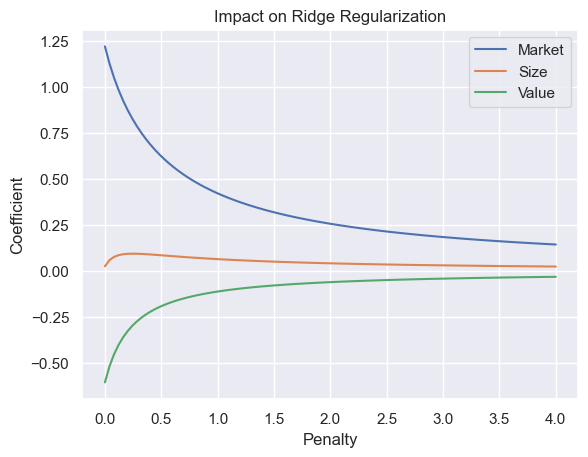

In [9]:
# 회귀분석 계수 데이터프레임
ridge_df = pd.DataFrame(ridge_coef_list, index=alpha_arr, columns=['Market', 'Size', 'Value'])

# 분석 결과 시각화
ridge_df.plot()
plt.title('Impact on Ridge Regularization')
plt.xlabel('Penalty')
plt.ylabel('Coefficient')

In [10]:
# Lasso 회귀분석 계수 저장을 위한 빈 리스트
lasso_coef_list = []

# 파라미터의 범위 설정
# Lasso는 알파를 작게 설정 (금방 0에 수렴)
alpha_arr = np.linspace(0.000, 0.010, 100)

# 파라미터 변화에 따른 Lasso 회귀분석
for alpha in alpha_arr:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    lasso_coef_list.append(lasso.coef_)

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_39347/2314893448.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X, y)
/opt/anaconda3/envs/finance/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/finance/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.651e-01, tolerance: 2.614e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fas

Text(0, 0.5, 'Coefficient')

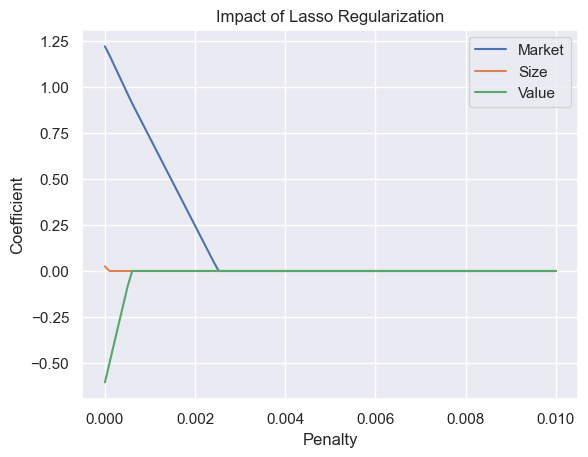

In [11]:
# 회귀분석 계수 데이터프레임
lasso_df = pd.DataFrame(lasso_coef_list, index=alpha_arr, columns=['Market', 'Size', 'Value'])

# 분석 결과 시각화
lasso_df.plot()
plt.title('Impact of Lasso Regularization')
plt.xlabel('Penalty')
plt.ylabel('Coefficient')